In [3]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import pandas as pd

import model_predict
from sklearn.model_selection import train_test_split

In [4]:
series, scaler = model_predict.read_data_series(scale=True, filter_early=True, file_index=2)

时间序列不连贯，缺失的月份： ['2013-11', '2014-12', '2015-04', '2017-12']
即将填充缺失的月份
月份平均：
月份
1     165.417333
2     107.969333
3      95.301778
4     123.181000
5     154.631111
6     202.507111
7     136.807500
8     117.749000
9     157.433000
10    156.723500
11    156.563429
12    136.816000
Name: 销量（箱）, dtype: float64


In [54]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        
        self.gru = nn.GRU(input_size, hidden_size,
                          num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: [batch, length, 3]
        x, _ = self.gru(x)
        x = self.fc(x[:, -1, :])
        # log_var, mean = x.split(1, dim=-1)
        # x = torch.randn_like(mean) * torch.exp(log_var / 2) + mean
        return x


model_parameters = {
    "input_size": 3, "hidden_size": 12, "num_layers": 1, "output_size": 1
}

In [56]:
from importlib import reload
reload(model_predict)
model_predict.train_rnn_model(GRUModel, model_parameters, series, learn_rate=1e-3, feature_length=16,
                              continue_train=False, test_shuffle=True, epochs=1000)

训练 GRUModel 模型
结果保存到： GRUModel_best.pth
Epoch [50/1000], Learn Rate: 1.0000e-03, Training Loss: 0.6188, Validation Loss: 1.1584
Epoch [100/1000], Learn Rate: 1.0000e-03, Training Loss: 0.4789, Validation Loss: 1.1319
Epoch [150/1000], Learn Rate: 1.0000e-03, Training Loss: 0.4117, Validation Loss: 1.1863
Epoch [200/1000], Learn Rate: 1.0000e-03, Training Loss: 0.3562, Validation Loss: 1.2141
Epoch [250/1000], Learn Rate: 1.0000e-03, Training Loss: 0.3080, Validation Loss: 1.2184
Epoch [300/1000], Learn Rate: 1.0000e-03, Training Loss: 0.2736, Validation Loss: 1.1958
Epoch [350/1000], Learn Rate: 1.0000e-03, Training Loss: 0.2422, Validation Loss: 1.1410
Epoch [400/1000], Learn Rate: 1.0000e-03, Training Loss: 0.2037, Validation Loss: 1.0385
Epoch [450/1000], Learn Rate: 1.0000e-03, Training Loss: 0.1401, Validation Loss: 0.9603
Epoch [500/1000], Learn Rate: 5.0000e-04, Training Loss: 0.1169, Validation Loss: 0.9738
Epoch [550/1000], Learn Rate: 5.0000e-04, Training Loss: 0.1047, Valida

从2016年10月开始后续数据推理
MSE: 7922.90
MAE: 72.59
R^2: -0.63
MAPE: 1.32


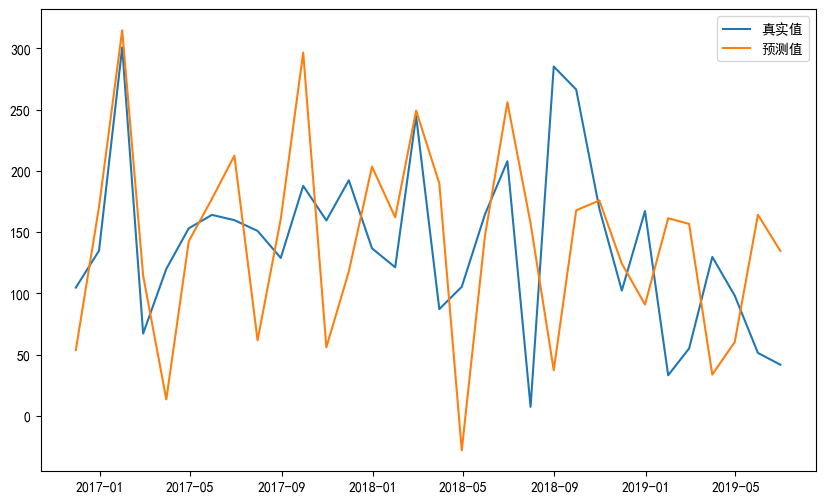

2016-11-30     53.799486
2016-12-31    170.608843
2017-01-31    314.755531
2017-02-28    114.499068
2017-03-31     13.535388
2017-04-30    142.571329
2017-05-31    177.215484
2017-06-30    212.437220
2017-07-31     61.733752
2017-08-31    160.775484
2017-09-30    296.562727
2017-10-31     56.034936
2017-11-30    117.936223
2017-12-31    203.456049
2018-01-31    162.096392
2018-02-28    249.177509
2018-03-31    189.832738
2018-04-30    -27.993753
2018-05-31    146.881354
2018-06-30    256.023940
2018-07-31    157.275894
2018-08-31     37.330779
2018-09-30    167.809520
2018-10-31    175.822709
2018-11-30    124.383546
2018-12-31     90.928154
2019-01-31    161.361415
2019-02-28    156.732524
2019-03-31     33.770505
2019-04-30     60.349727
2019-05-31    164.215300
2019-06-30    134.664411
Freq: M, dtype: float64

In [58]:
model = model_predict.load_rnn_model_best(GRUModel, model_parameters)
model_predict.predict_to_future_rnn(model, series, scaler, feature_length=16, last_months=32, months=32)